# Validate chandra_aca.attitude.calc_att

Use the OBC y/z centroids and the star catalog y/z values and
star catalog reference attitude to compute the estimated attitude
as a function of time.  Then compare to the OBC estimated attitude.

This is done for [obsid 18098](http://kadi.cfa.harvard.edu/mica/?obsid_or_date=18098).

In [1]:
import numpy as np

from Quaternion import Quat
from Ska.quatutil import radec2yagzag
from Ska.engarchive import fetch
from kadi import events
from astropy.io import ascii
import matplotlib.pyplot as plt
import agasc

from chandra_aca.attitude import calc_roll, calc_roll_pitch_yaw, _calc_roll_pitch_yaw, calc_att
%matplotlib inline

In [2]:
fetch.data_source.set('maude')  # If on a remote computer without CXC data access

In [3]:
dwell = events.dwells.filter(obsid=18098)[0]

In [4]:
# Get OBC estimated attitude
atts = fetch.MSIDset(['aoattqt*'], dwell.tstart + 500, dwell.tstart + 1500)

In [5]:
# Get observed yag/zag data
msids = ['aoacyan{}'.format(ii) for ii in (3,4,5,6,7)] + ['aoaczan{}'.format(ii) for ii in (3,4,5,6,7)]
dats = fetch.MSIDset(msids, dwell.tstart + 480, dwell.tstart + 1520)

In [6]:
atts.interpolate(times=atts['aoattqt1'].times, bad_union=True)

In [7]:
# Subtract time offset between MAUDE OBC centroids and aoattqt
for msid in dats:
    dats[msid].times -= 2.4  # from plot in https://github.com/sot/chandra_aca/pull/25

In [8]:
dats.interpolate(times=atts.times)

In [9]:
q_atts = np.array([atts['aoattqt{}'.format(ii)].vals for ii in (1,2,3,4)]).transpose()

In [10]:
yags_obs = np.array([dats['aoacyan{}'.format(ii)].vals for ii in (3,4,5,6,7)]).transpose()
zags_obs = np.array([dats['aoaczan{}'.format(ii)].vals for ii in (3,4,5,6,7)]).transpose()

In [11]:
yags_obs

array([[ -654.975,  -102.575,  1555.725, -1708.575, -2327.85 ],
       [ -654.975,  -102.575,  1555.725, -1708.575, -2327.85 ],
       [ -655.   ,  -102.625,  1555.7  , -1708.6  , -2327.875],
       ..., 
       [ -654.575,  -102.175,  1556.1  , -1708.225, -2327.4  ],
       [ -654.625,  -102.175,  1556.05 , -1708.25 , -2327.4  ],
       [ -654.625,  -102.175,  1556.05 , -1708.25 , -2327.4  ]])

In [12]:
# Obsid 18098 guide stars
cat = """
3   327689032   BOT  6x6   0.985   6.353   7.859   -647  -1472  20   1  120    
4   327691744   BOT  6x6   0.985   8.596  10.094    -95   -600  20   1  120          
5   327691864   BOT  6x6   0.985   7.985   9.484   1563   -358  20   1  120          
6   327681976   GUI  6x6     ---   8.026   9.531  -1701  -2331   1   1   25          
7   327691984   GUI  6x6     ---   7.894   9.391  -2320  -1570   1   1   25"""
cat = ascii.read(cat, format='no_header')

In [14]:
q_att = Quat([ 142.668983,    36.033299,   176.121686])
yags = []
zags = []
for agasc_id in cat['col2']:
    star = agasc.get_star(agasc_id, date='2016:039:09:23:10')
    yag, zag = radec2yagzag(star['RA_PMCORR'], star['DEC_PMCORR'], q_att)
    yags.append(yag * 3600)
    zags.append(zag * 3600)

In [15]:
# Compute the attitudes from observed centroids
q_atts_obs = calc_att(q_att, yags, zags, yags_obs, zags_obs)

In [16]:
# Get attitude differences as delta roll, pitch, yaw values
dr = []
dp = []
dy = []
for q_att_obs, q_att in zip(q_atts_obs, q_atts):
    q_att = Quat(q_att)
    dq = q_att.dq(q_att_obs)
    dr.append(dq.roll0 * 3600)
    dp.append(dq.pitch * 3600)
    dy.append(dq.yaw * 3600)

In [17]:
times = dats.times - dats.times[0]

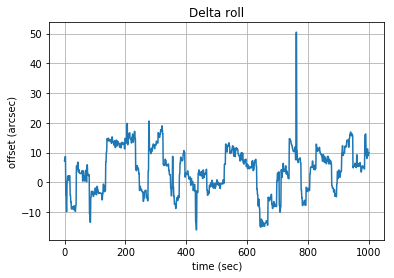

In [18]:
plt.plot(times, dr)
plt.grid()
plt.title('Delta roll')
plt.ylabel('offset (arcsec)')
plt.xlabel('time (sec)');

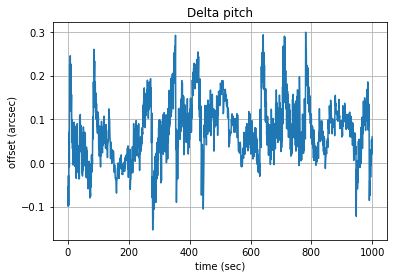

In [19]:
plt.plot(times, dp)
plt.grid()
plt.title('Delta pitch')
plt.ylabel('offset (arcsec)')
plt.xlabel('time (sec)');

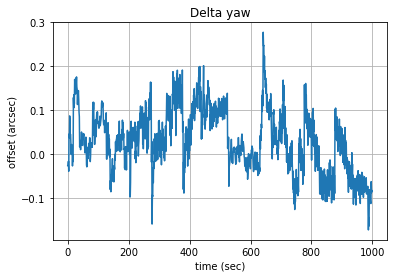

In [20]:
plt.plot(times, dy)
plt.grid()
plt.title('Delta yaw')
plt.ylabel('offset (arcsec)')
plt.xlabel('time (sec)');